# Measurements of the properties of galaxies by reducing their multi-dimensional color-space


In [8]:
import numpy as np
import scipy 
from SOMPY import sompy
from scipy import interpolate
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-dark')

def col(m1,m2):
    '''Returns colors of the galaxies given their two 
    magnitudes.'''
    
    c = np.zeros_like(m1)
    for i in range(len(m1)):
        if 13.0 < m1[i] <80.0 and 13.0 < m2[i] < 80.0:
            c[i]=m1[i]-m2[i]
        else:        
            c[i]=99.
    return c

catdir = 'catalogs/'

## Loading "model" Galaxy data 

In [9]:
redshift=1.0
    
def color_vector(redshift):
    catal = np.genfromtxt(catdir+'All_mags_z1.0.cat',dtype=[('names', 'S50'), ('u', 'f8'), ('b', 'f8'), ('v', 'f8'), ('r', 'f8'),('i', 'f8'), ('z', 'f8'), ('y', 'f8'), ('j', 'f8'), ('h', 'f8'), ('k', 'f8'),('ch1', 'f8'), ('ch2', 'f8'), ('ch3', 'f8'), ('ch4', 'f8')])
    met,age,tau,ebv,ml=np.zeros_like(catal['b']),np.zeros_like(catal['b']),np.zeros_like(catal['b']),np.zeros_like(catal['b']),np.zeros_like(catal['b']),
    uvj=np.zeros_like(catal['names'])
    for i in range(len(catal['names'])):
        met[i]=int(catal['names'][i][28:30])
        age[i]=float(catal['names'][i][9:15])
        tau[i]=float(catal['names'][i][19:24])
        ebv[i]=float(catal['names'][i][34:38])


    ub = col(catal['u'],catal['b'])
    bv = col(catal['b'],catal['v'])
    vr = col(catal['v'],catal['r'])
    ri = col(catal['r'],catal['i'])
    iz = col(catal['i'],catal['z'])
    zy = col(catal['z'],catal['y'])
    yj = col(catal['y'],catal['j'])
    jh = col(catal['j'],catal['h'])
    hk = col(catal['h'],catal['k'])
    kc1 = col(catal['k'],catal['ch1'])
    c1c2 = col(catal['ch1'],catal['ch2'])

    selage = (~np.isnan(ub))&(~np.isnan(bv))&(~np.isnan(vr))&(~np.isnan(ri))&(~np.isnan(iz))&(~np.isnan(zy))&(~np.isnan(yj))&(~np.isnan(jh))&(~np.isnan(hk))&(~np.isnan(kc1))&(~np.isnan(c1c2))
    data_model = np.array([ub[selage],bv[selage],vr[selage],ri[selage],iz[selage],zy[selage],yj[selage],jh[selage],hk[selage],kc1[selage],c1c2[selage]]).T
    par = np.array([met[selage],age[selage],tau[selage],ebv[selage]])
    return data_model,par

data_model, par= color_vector(redshift)
print (np.shape(data_model), par.shape)

((16400, 11), (4, 16400))


In [10]:
# visually inspecting the models

def plot_sed(n):
    '''to plot n random galaxy seds given multi-band flux densities'''
    wavelengths = [300,435,606,650,775,850,1000,1250,1600,2200]
    catal=np.genfromtxt(catdir+'All_mags_z1.0.cat',dtype=[('names', 'S50'), ('u', 'f8'), ('b', 'f8'), ('v', 'f8'), ('r', 'f8'),('i', 'f8'), ('z', 'f8'), ('y', 'f8'), ('j', 'f8'), ('h', 'f8'), ('k', 'f8'),('ch1', 'f8'), ('ch2', 'f8'), ('ch3', 'f8'), ('ch4', 'f8')])

    for i in range(n):
        num = np.random.randint(len(catal['b']))
        fluxes = [catal['u'][num],catal['b'][num],catal['v'][num],catal['r'][num],catal['i'][num],catal['z'][num],catal['y'][num],catal['j'][num],catal['h'][num],catal['k'][num]]
        plt.plot(wavelengths,fluxes,marker='o')
    
    plt.xlim([250,2300])
    plt.ylim([43,65])
    plt.xlabel('wavelegth (nm)',size=15)
    plt.ylabel('magnitude (arbitraty unit)',size=15)
    plt.text(1400,60,'Model galaxy SEDs',size=15)
    return fluxes

a = plot_sed(100)

## Training a SOM on 11 dimenstional space of model galaxy colors

In [35]:
msz0 = 80
msz1 = 60
sm = sompy.SOMFactory.build(data_model, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train()

 Training...
 pca_linear_initialization took: 0.078000 seconds
 Rough training...
 radius_ini: 10.000000 , radius_final: 2.500000, trainlen: 9

 epoch: 1 ---> elapsed time:  1.009000, quantization error: 0.605051

 epoch: 2 ---> elapsed time:  0.983000, quantization error: 0.391716

 epoch: 3 ---> elapsed time:  1.046000, quantization error: 0.285274

 epoch: 4 ---> elapsed time:  1.104000, quantization error: 0.255470

 epoch: 5 ---> elapsed time:  1.022000, quantization error: 0.232993

 epoch: 6 ---> elapsed time:  1.034000, quantization error: 0.208136

 epoch: 7 ---> elapsed time:  1.328000, quantization error: 0.183888

 epoch: 8 ---> elapsed time:  1.184000, quantization error: 0.160752

 epoch: 9 ---> elapsed time:  1.032000, quantization error: 0.138895

 Finetune training...
 radius_ini: 2.500000 , radius_final: 1.000000, trainlen: 12

 epoch: 1 ---> elapsed time:  1.052000, quantization error: 0.119004

 epoch: 2 ---> elapsed time:  1.505000, quantization error: 0.116519

 e

(4800, 11)


<function matplotlib.pyplot.tight_layout>

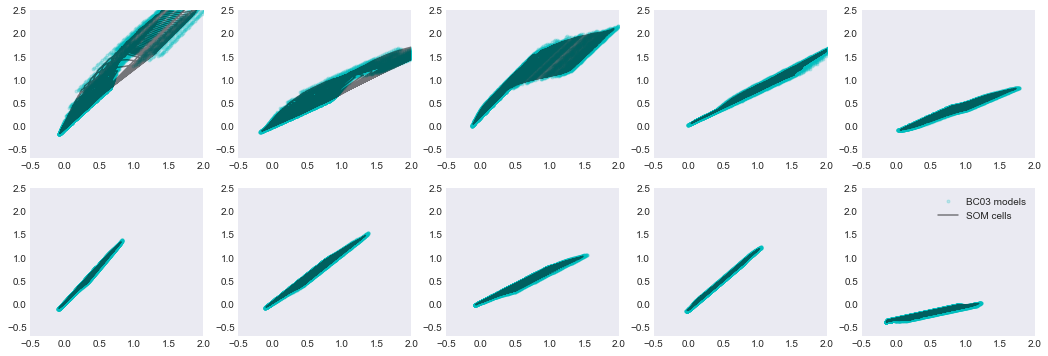

In [39]:
# checking if SOM is trained well by visually inspecting distribution of model galaxy colors and SOM cells
codebook = sm._normalizer.denormalize_by(sm.data_raw,sm.codebook.matrix)
print(codebook.shape)

plt.figure(figsize=(18,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.plot(data_model[:,i],data_model[:,i+1],'c.',alpha=0.2,label='BC03 models')
    bbb=plt.plot(codebook[:,i],codebook[:,i+1],'k-',alpha=0.5,label='SOM cells')
    plt.xlim([-0.5,2])
    plt.ylim([-0.7,2.5])
plt.legend()
plt.tight_layout


# Maps of physical properties

In [46]:
## specific SFR measured from tau and age
def integrand(t, tau):
     return np.exp(-t/tau)

def ssfr(age,tau):
    I = quad(integrand, 0, age, args=(tau))[0]
    return np.log10(np.exp(-age/tau)/I)-9.0

# Mapping model galaxies back to trained SOM
a=sm.bmu_ind_to_xy(sm.project_data(data_model))

# assigining physical properties of each SED to a SOM cell where it maps
mass=np.genfromtxt(catdir+'Mass_table_fromcsp.cat')
x,y,age,tau,ebv,mk,met,ssf = np.zeros(len(a)),np.zeros(len(a)),np.zeros(len(a)),np.zeros(len(a)),np.zeros(len(a)),np.zeros(len(a)),np.zeros(len(a)),np.zeros(len(a))

for k,value in enumerate(a):
    x[k]=value[0]
    y[k]=value[1]
    met[k]=(par[0][k])
    age[k]=(par[1][k])
    tau[k]=(par[2][k])
    ebv[k]=(par[3][k])
    ssf[k]=ssfr(age[k],tau[k])
    for juj in range(len(mass[:,2])):
        if (np.abs(mass[juj,2]-np.log10(10.0**9.0*np.float(par[1][k])))<=0.01)&(np.abs(mass[juj,0]-par[2][k])<0.001):
            mk[k]=(mass[juj,7])
            

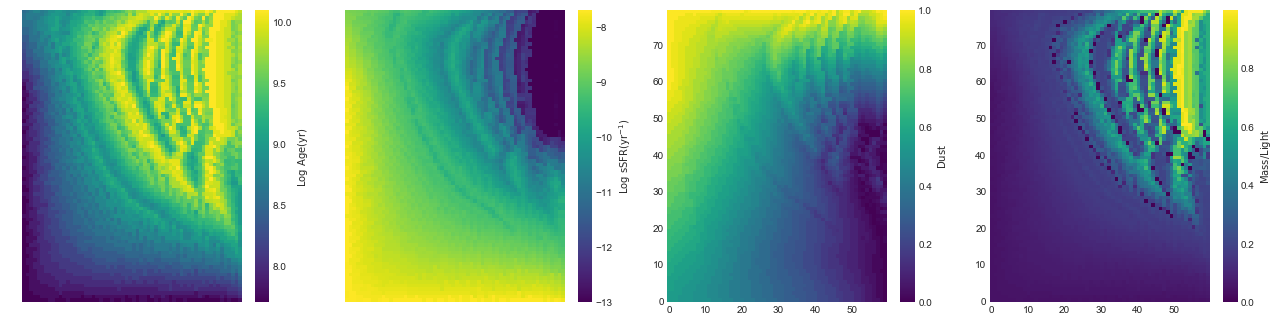

In [65]:
# Measuring median of properties of Models mapped to each cell to make maps of physical properties:

def filler(m):
    ''' Fill the empty spots of a 2d array with linear interpolation'''
    mask = ~(np.isnan(m))
    xx, yy = np.meshgrid(np.arange(np.shape(m)[1]), np.arange(np.shape(m)[0]))
    xym = np.vstack( (np.ravel(xx[mask]), np.ravel(yy[mask])) ).T
    data0 = np.ravel( m[mask] )
    interp0 = scipy.interpolate.NearestNDInterpolator( xym, data0 )
    result0 = interp0(np.ravel(xx), np.ravel(yy)).reshape( xx.shape )
    return result0

DEMage,DEMebv,DEMmlr,DEMtau = np.zeros((msz0,msz1)), np.zeros((msz0,msz1)), np.zeros((msz0,msz1)), np.zeros((msz0,msz1))
for i in range(msz0):
    for j in range(msz1):
        there = (x==i)&(y==j)
        DEMage[i,j] = np.median(age[there])
        DEMebv[i,j] = np.median(ebv[there])
        DEMmlr[i,j] = np.median(mk[there])
        DEMtau[i,j] = np.median(ssf[there])

plt.figure(figsize=(18,4.5))
plt.subplot(1,4,1)
im = plt.imshow(filler(np.log10(DEMage*10.0**9)),origin='lower',cmap='viridis')
plt.axis('off')
plt.colorbar(im, label = r'$\rm Log\ Age (yr)$')

plt.subplot(1,4,2)
im = plt.imshow(filler(DEMtau),vmin=-13,origin='lower',cmap='viridis')
plt.axis('off')
plt.colorbar(im, label=r'$\rm Log\ sSFR (yr^{-1})$')

plt.subplot(1,4,3)
im = plt.imshow(filler(DEMebv),origin='lower',cmap='viridis')
cb=plt.colorbar(im, label=r'$\rm Dust$')

plt.subplot(1,4,4)
im=plt.imshow(filler(DEMmlr),origin='lower',cmap='viridis')
plt.colorbar(im, label=r'$\rm Mass/Light$')

plt.tight_layout()


### Data from real observations

In [66]:
# loading real galaxy data from the COSMOS field
ndtype=[('id', "S15"), ('ra', float), ('dec', float),('ubc',float), ('bvc',float),('vrc',float), ('ric',float), 
        ('izc',float), ('zyc',float), ('yjc',float), ('jhc',float), ('hkc',float),('k1c',float), ('c12c',float),
        ('c23c',float),('c34c',float),('eub',float), ('ebv',float),('evr',float), ('eri',float), 
        ('eiz',float), ('ezy',float), ('eyj',float), ('ejh',float), ('ehk',float),('ekc',float), ('ec12',float),
        ('ec23',float),('ec34',float),('zc',float), ('massc',float), ('sfrc',float), ('agec',float), 
        ('ebvc',float), ('kmag',float),('ekmag',float), ('MU',float),('MV',float), ('MJ',float), ('overdensity',float),('env', "S15")]

cosmos=np.genfromtxt(catdir+'cosmos_z1_color+env.cat',dtype=ndtype)

#shifts to galaxy colors to match model colors
mub,mbv,mvr,mri,miz,mzy,myj,mjh,mhk,mk1,mc12=1.0,1.2,1.4,1.6,1.1,1.4,2.0,1.5,1.6,1.2,0.85
cub,cbv,cvr,cri,ciz,czy,cyj,cjh,chk,ck1,cc12=0.2,-0.4,0.1,-0.3,0.1,0.1,-0.2,0.2,-0.2,0.1,0.04

ra=np.array(cosmos['ra'])
dec=np.array(cosmos['dec'])

ubc=mub*np.array(cosmos['ubc'])+cub
bvc=mbv*np.array(cosmos['bvc'])+cbv
vrc=mvr*np.array(cosmos['vrc'])+cvr
ric=mri*np.array(cosmos['ric'])+cri
izc=miz*np.array(cosmos['izc'])+ciz
zyc=mzy*np.array(cosmos['zyc'])+czy
yjc=myj*np.array(cosmos['yjc'])+cyj
jhc=mjh*np.array(cosmos['jhc'])+cjh
hkc=mhk*np.array(cosmos['hkc'])+chk
k1c=mk1*np.array(cosmos['k1c'])+ck1
c12c=mc12*np.array(cosmos['c12c'])+cc12

zc = np.array(cosmos['zc'])
massc = np.array(cosmos['massc'])

data_cosmos = np.array([ubc,bvc,vrc,ric,izc,zyc,yjc,jhc,hkc,k1c,c12c]).T
print(data_cosmos.shape)

(13718, 11)


# Which parts of the model space is representative of data?

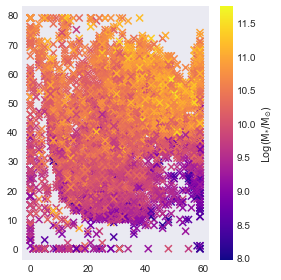

In [68]:
#Mapping real observations to the SOM trained on models
ac=sm.bmu_ind_to_xy(sm.project_data(data_cosmos))
xpz,ypz=np.zeros(len(ac)),np.zeros(len(ac))

for k, value in enumerate(ac):
    xpz[k]=value[0]
    ypz[k]=value[1]


#where do galaxies sit on the model space?
plt.figure(figsize=(4,4))
plt.scatter(ypz,xpz,c=massc,s=30,marker='x',cmap='plasma')
plt.colorbar(label=r'$\rm Log(M_{*}/M_{\odot})$')
plt.tight_layout()

# On the accuracy of SOM measurements:

/Users/hooshang/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


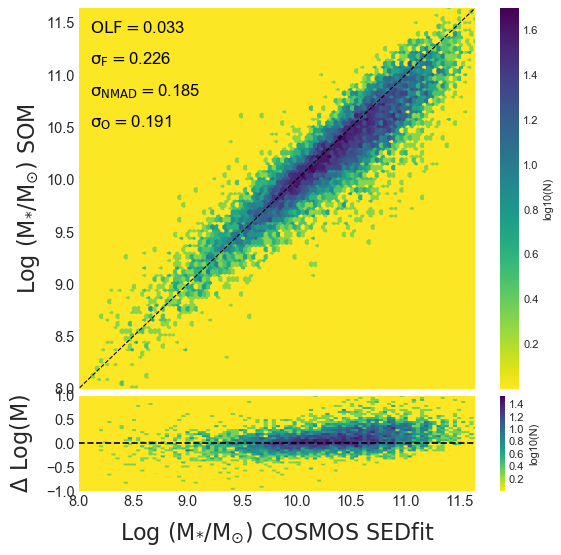

In [70]:
# Reading of measured properties from mapping to the SOM
cos = np.genfromtxt(catdir+'SOM_props_z1cosmos.cat')
m_real,m_som = massc, cos[:,5]

# measuring some statistics 
def rms(a):
    return np.sqrt(np.mean(np.square(a)))

mass1=m_real[np.isfinite(m_som)&np.isfinite(m_real)&(m_som<13)]
mass2=m_som[np.isfinite(m_som)&np.isfinite(m_real)&(m_som<13)]
mcanhst2=np.array(mass1-mass2)
sel=(np.abs(mcanhst2) > 0.5)
olf=float(np.sum(sel))/len(sel)
sel=(np.abs(mcanhst2) <=0.5)
#print 'stats'+'\t'+str(round(olf,3))+'\t'+str(round(rms(mcanhst2),3))+'\t'+str(round(1.48*np.median(np.abs(mcanhst2)),3))+'\t'+str(round(rms(mcanhst2[sel]),3))



fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w')
gs = gridspec.GridSpec(2, 1,height_ratios=[4,1],hspace=0.03) 
ax0 = plt.subplot(gs[0])
hb=ax0.hexbin(mass1,mass2,vmin=0.001, gridsize=100, bins='log',cmap='viridis_r')
cb = fig.colorbar(hb, ax=ax0)
cb.set_label('log10(N)')
ax0.set_ylabel(r'$\rm Log\ (M_{*}/M_{\odot}) \ SOM$',fontsize=20)
ax0.plot([4,12],[4,12],'k--',linewidth=1)
ax0.set_xlim([8,max(mass2)])
ax0.set_ylim([8,max(mass2)])
ax0.text(8.1,11.4,r'$\rm OLF = $'+str(round(olf,3)),size=15,color='k')
ax0.text(8.1,11.1,r'$\rm \sigma _{F}=$'+str(round(rms(mcanhst2),3)),size=15,color='k')
ax0.text(8.1,10.8,r'$\rm \sigma _{NMAD}=$'+str(round(1.48*np.median(np.abs(mcanhst2)),3)),size=15,color='k')
ax0.text(8.1,10.5,r'$\rm \sigma_O=$'+str(round(rms(mcanhst2[sel]),3)),size=15,color='k')

ax0.axes.get_xaxis().set_ticks([])
plt.tick_params(axis='both', which='major', labelsize=13)

ax2 = plt.subplot(gs[1])
ax2.set_xlabel(r'$\rm Log\ (M_{*}/M_{\odot})\ COSMOS\ SEDfit$',fontsize=20, labelpad=10)
ax2.set_ylabel(r'$\rm \Delta \ Log(M)$',fontsize=20,labelpad=10)
ax2.set_ylim([-0.5,0.5])
hb=ax2.hexbin(mass1,mcanhst2,vmin=0.001, gridsize=100, bins='log',cmap='viridis_r')
cb = fig.colorbar(hb, ax=ax2)
cb.set_label('log10(N)')
ax2.plot([6,12],[0,0],'k--')
ax2.set_xlim([8,max(mass2)])
ax2.set_ylim([-1.,1.])
ax2.yaxis.set_ticks([-1.0,-0.5,0.,0.5,1.0])
plt.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
